# Figure 1. Bibliographical information about p63 enhancers used in the study.

In [1]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import os
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
#define useful functions
#set seaborn theme for nice figures
sns.set_theme(style="ticks",rc={"axes.spines.right": False, "axes.spines.top": False, 'font.size': 10},
			  font='arial')
#import key tables
os.chdir('..\data')
fig_out_path = r'..\figures'
#import table for MCF10A data where all 5 variants are matched for both replicates
df = pd.read_excel('Table S3.xlsx', sheet_name='MCF10A_WT_p53KO')
df.sample(5)

,loc,enhancer_variant,cell_line,RNA/DNA,activity,obs_score,p63RE_class,strand,p63RE_type,gc,obs_p53
79721,chr15_93527689_93527708,shuffle,MCF10A p53KO,0.512786,Unchanged,8,primary,+,p53RE+p63RE,42.857143,NaN
88665,chr3_183295612_183295636,flankShuffle,MCF10A p53KO,0.689411,Repressing,9,primary,+,Unique p63RE,55.833333,NaN
86205,chr17_6279805_6279819,flankShuffle,MCF10A p53KO,2.173829,Unchanged,11,tertiary,-,Unique p63RE,58.333333,NaN
80831,chr7_135335426_135335440,shuffle,MCF10A p53KO,0.836248,Activating,8,tertiary,+,Unique p63RE,65.833333,NaN
70788,chr8_109620907_109620921,mut,MCF10A p53KO,0.229672,Unchanged,8,senary,+,Unique p63RE,39.166667,NaN


 - Extract nearest TSS and nearest transcript information

In [2]:
import bioframe as bf #deals with genomic ranges
#get genomic annotations
#dowloaded from https://hgdownload.cse.ucsc.edu/goldenpath/hg38/bigZips/genes/hg38.refGene.gtf.gz
all_enh = pd.read_csv('p63enh_starrseq_info.csv', usecols=['p63RE_chrom','p63RE_start','p63RE_stop'])
gene_annot = '..\..\..\..\genome_files\hg38.refGene.gtf'
genes = bf.read_table(gene_annot, schema='gtf').query('feature=="transcript"')
genes.drop_duplicates(subset = ['chrom','start','end'], inplace=True)
genes.drop(columns=['source', 'feature','score','frame'], inplace=True)
#ensure correct dtype for bioframe
all_enh = all_enh.astype({"p63RE_start": int, "p63RE_stop": int})
#get a table with closest p63 enhancer distances to transcripts (start or end)
distance_tx = bf.closest(all_enh, genes,  cols1 = ['p63RE_chrom','p63RE_start','p63RE_stop'],
							  cols2 = ['chrom','start','end'], suffixes = ['','_transcript'])
distance_tx.rename(columns={'distance':'distance_tx'}, inplace=True)
#get a table with closest p63 enhancer distances to TSS
genes['TSS'] = genes.apply(lambda row: row.start if row.strand  == '+' else row.end, axis='columns')
distance_tss = bf.closest(all_enh, genes,  cols1 = ['p63RE_chrom','p63RE_start','p63RE_stop'],
							  cols2 = ['chrom','TSS','TSS'], suffixes = ['','_TSS'])
distance_tss.rename(columns={'distance':'distance_tss'}, inplace=True)
#make a separate table with custom ranges so that bar widths are the same
mybins = [-1,5000,10000,25000,50000,100000,250000,1500000]
bin_labels = ['0 - 5k', '5 - 10k', '10 - 25k', '25- 50k','50 - 100k', '100 - 250k', '250k+']
binned_dist_tx = pd.cut(distance_tx['distance_tx'], bins=mybins, labels = bin_labels)
binned_dist_tss = pd.cut(distance_tss['distance_tss'], bins=mybins, labels = bin_labels)
distance_tx['rel_to_gene'] = distance_tx['distance_tx'].apply(lambda x: 'Intragenic' if x == 0 else 'Intergenic')
#extract gene symbol
distance_tx['nearest_tx_name'] = distance_tx.attributes_transcript.apply(lambda x: re.search(r'gene_id "([^"]+)"', x).group(1))
distance_tss['nearest_tss_name'] = distance_tss.attributes_TSS.apply(lambda x: re.search(r'gene_id "([^"]+)"', x).group(1))
distance_tss
distance_tss.sample(5)
#exported this 2024-08-02
# distance_tx.to_csv('Distance_transcript.csv', index=False) 
# distance_tss.to_csv('Distance_tss_all.csv', index=False)

,p63RE_chrom,p63RE_start,p63RE_stop,chrom_TSS,start_TSS,end_TSS,strand_TSS,attributes_TSS,TSS_TSS,distance_tss,nearest_tss_name
6164,chr16,78564019,78564038,chr16,78099654.0,79212667.0,+,"gene_id ""WWOX""; transcript_id ""NM_001291997""; ...",78099654,464365,WWOX
12174,chr4,10284021,10284040,chr4,10074339.0,10116799.0,-,"gene_id ""WDR1""; transcript_id ""NM_017491""; ge...",10116799,167222,WDR1
1627,chr1,175531028,175531047,chr1,175315195.0,175743595.0,-,"gene_id ""TNR""; transcript_id ""NM_001328635""; ...",175743595,212548,TNR
1081,chr1,91864463,91864482,chr1,91680343.0,91886151.0,-,"gene_id ""TGFBR3""; transcript_id ""NM_003243""; ...",91886151,21669,TGFBR3
15056,chr7,105185793,105185817,chr7,105116374.0,105269077.0,-,"gene_id ""SRPK2""; transcript_id ""NM_001350744"";...",105269077,83260,SRPK2


 - unused, distance to the nearest transcript

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


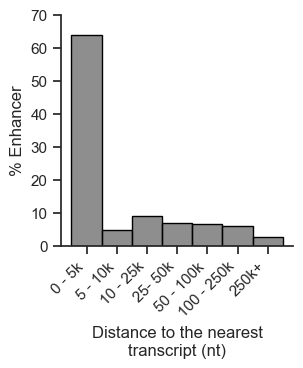

In [10]:
fig, ax = plt.subplots(figsize=(3,3))
sns.histplot(binned_dist_tx, stat='percent', color = 'dimgrey', linewidth = 1, edgecolor = 'black', ax=ax).set(xlabel = 'Distance to the nearest\ntranscript (nt)', ylabel = '% Regulatory elements', ylim = (0,70))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

## Figure 1C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


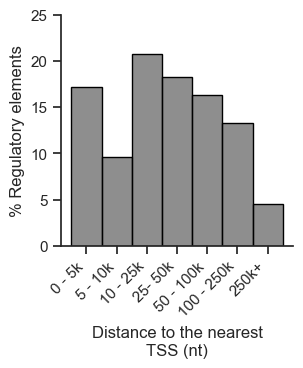

In [7]:
#plot Figure 1D
fig, ax = plt.subplots(figsize=(3,3))
sns.histplot(binned_dist_tss, stat='percent', color = 'dimgrey', linewidth = 1, edgecolor = 'black', ax=ax).set(xlabel = 'Distance to the nearest\nTSS (nt)', ylabel = '% Regulatory elements', ylim = (0,25))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
fig.savefig(os.path.join(fig_out_path,'1C.eps'), dpi=300, transparent=True, bbox_inches='tight')

## Figure 1D

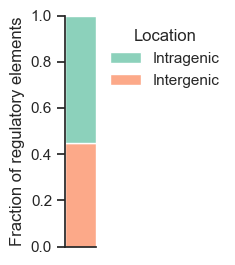

In [5]:
#plot Figure 1D Stacked bar chart of intragenic and intergenic
#need place holder for the stacked barchart
distance_tx['xlabel'] = 'xlabel'
fig, ax = plt.subplots(figsize=(0.4,3))
sns.histplot(
    data=distance_tx,
    x="xlabel", hue="rel_to_gene",
    multiple="fill", stat="percent", palette= 'Set2',
    discrete=True, shrink=.6,ax=ax).set(ylabel = 'Fraction of regulatory elements',xlabel=None)
ax.axes.get_xaxis().set_visible(False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title = 'Location')
fig.savefig(os.path.join(fig_out_path,'1D.pdf'), dpi=300, transparent=True, bbox_inches='tight')

In [6]:
distance_tx.rel_to_gene.value_counts()

Intragenic    9535
Intergenic    7775
Name: rel_to_gene, dtype: int64

## Figure 1E

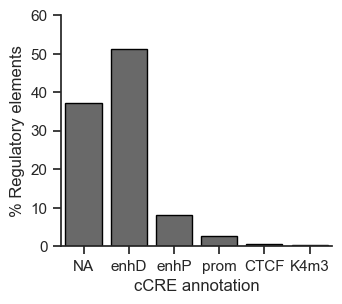

In [8]:
# Figure 1E. cCREs
df_cre = pd.read_csv('p63MPRA_regions_cCRE_numbers.04jan2024.csv', index_col=0)
df_cre.replace({np.nan : 'NA'}, inplace=True)
df_cre['% Enhancers'] = (df_cre.n / df_cre.n.sum()) * 100

fig, ax = plt.subplots(figsize=(3.5,3))
sns.barplot(data=df_cre, x='ucsc_label', y='% Enhancers',order=['NA', 'enhD', 'enhP', 'prom', 'CTCF', 'K4m3'],
			color = 'dimgrey',linewidth = 1, edgecolor = 'black', ax=ax).set(xlabel = 'cCRE annotation', ylim=(0,60), ylabel = '% Regulatory elements')
fig.savefig(os.path.join(fig_out_path,'1E.eps'), dpi=300, transparent=True, bbox_inches='tight')

## Figure 1F

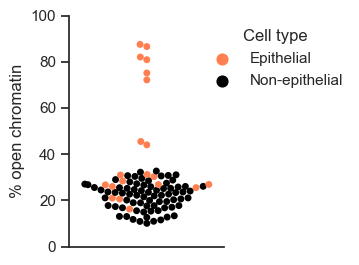

In [15]:
df_cell = pd.read_csv('dhs_count_by_cell_type.04jan2024.csv', index_col=0).reset_index()
df_cell.drop(columns='index', inplace=True)
df_cell['xlabel'] = 'xlabel'
df_cell['% open'] = (df_cell.open / (df_cell.closed + df_cell.open)) * 100
fig1F, ax = plt.subplots(figsize=(2,3))
sns.swarmplot(data=df_cell, x = 'xlabel',y='% open', hue='epi_cell',palette={'Epithelial':'coral', 'Non-epithelial':'black'}, ax=ax).set(ylabel = '% open chromatin', xlabel = 'Cell Types', ylim=(0,100))
sns.move_legend(ax, "upper left", bbox_to_anchor=(0.8, 1), frameon=False, title = 'Cell type')
ax.axes.get_xaxis().set_visible(False)
fig1F.savefig(os.path.join(fig_out_path,'1F.eps'), dpi=300, transparent=True, bbox_inches='tight')

## Figure 1G

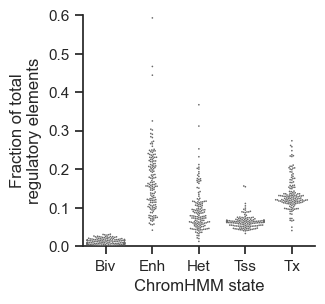

In [12]:
#plot Figure 1G
chrhmm = pd.read_csv('Percent_chromHMM_by_cell_type.for_heatmap.csv', index_col=0)
chrhmm_long = chrhmm.melt(id_vars=['Biosample.term.name'], value_vars=['Biv', 'Enh', 'Het','Tss', 'Tx'], var_name='ChromHMM state', value_name='Fraction of total')
fig, ax = plt.subplots(figsize=(3,3))
sns.swarmplot(data=chrhmm_long, x='ChromHMM state', y='Fraction of total', color = 'dimgrey',size=1.2, ax=ax).set(ylim=(0,0.6),ylabel='Fraction of total\nregulatory elements')
fig.savefig(os.path.join(fig_out_path,'1G.eps'), dpi=300, transparent=True, bbox_inches='tight')
#sns.color_palette(palette='binary')[-2]

## Figure 1H

 - process table for stacked bar chart

In [13]:
chrhmm = pd.read_csv('Percent_chromHMM_by_cell_type.for_heatmap.csv', index_col=0)
#reshape table for stacked barchart
chrhmm_long = chrhmm.melt(id_vars=['Biosample.term.name'], value_vars=['Biv', 'Enh','Quies', 'Het','Tss', 'Tx'], var_name='ChromHMM state', value_name='Fraction of total')
chrhmm_long['xlabel'] = chrhmm_long['Biosample.term.name'].apply(lambda x: 'MCF10A' if x == 'MCF10A' else 'ENCODE\naverage') #\n to break up xlabel
chrhmm_long.head(5)

,Biosample.term.name,ChromHMM state,Fraction of total,xlabel
0,HPDE6-E6E7,Biv,0.006926,ENCODE\naverage
1,RWPE2,Biv,0.005480,ENCODE\naverage
2,MCF10A,Biv,0.004377,MCF10A
3,RWPE1,Biv,0.005024,ENCODE\naverage
4,H54,Biv,0.029761,ENCODE\naverage


In [14]:
collapsed = chrhmm_long.groupby(['xlabel','ChromHMM state'])['Fraction of total'].mean().to_frame().reset_index()
collapsed.sample(5)


,xlabel,ChromHMM state,Fraction of total
11,MCF10A,Tx,0.112289
6,MCF10A,Biv,0.004377
3,ENCODE\naverage,Quies,0.515382
7,MCF10A,Enh,0.444303
5,ENCODE\naverage,Tx,0.135548


In [15]:
tbl = collapsed.pivot(index='xlabel', columns='ChromHMM state', values='Fraction of total')
tbl

ChromHMM state,Biv,Enh,Het,Quies,Tss,Tx
xlabel,,,,,,
ENCODE\naverage,0.012501,0.170310,0.094196,0.515382,0.063358,0.135548
MCF10A,0.004377,0.444303,0.060531,0.261798,0.111071,0.112289


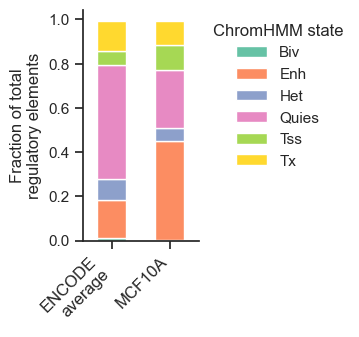

In [16]:
fig, ax = plt.subplots(figsize=(1.5,3))
tbl.plot(kind='bar', stacked=True, color = sns.color_palette(palette='Set2'), ax=ax).set(xlabel=None, ylabel='Fraction of total\nregulatory elements')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45, size=12,ha='right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False, title = 'ChromHMM state')
fig.savefig(os.path.join(fig_out_path,'1H.eps'), dpi=300, transparent=True, bbox_inches='tight')

## Figure 1J
 - Run some statistical tests to check for normality before commiting to one in graphs

In [18]:
#test for data normality to choose a statistical test
from scipy import stats
from scipy.stats import anderson
result = anderson(df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'WT')]['RNA/DNA'])
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 1344.294
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


In [19]:
# since data is not normally distributed
# run Kruskal-wallis comparison to see if there's a difference between all 5 variants in aggregate
stats.kruskal(df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'flankShuffle')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'WT')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'mut')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'shuffle')]['RNA/DNA'],
			  df[(df.cell_line == 'MCF10A') & (df.enhancer_variant == 'fullShuffle')]['RNA/DNA'])

KruskalResult(statistic=1816.052470970863, pvalue=0.0)

In [20]:
from scikit_posthocs import posthoc_dunn
# posthoc dunn test, with correction for multiple testing
dunn = posthoc_dunn(df[df.cell_line == 'MCF10A'], val_col="RNA/DNA", group_col="enhancer_variant", p_adjust="bonferroni")
dunn = dunn.melt(ignore_index=False).reset_index().dropna()
#only keep WT to other 4 variants comparison
dunn = dunn[(dunn.variable == 'WT') & (dunn['index'] != 'WT')]
dunn

,index,variable,value
1,flankShuffle,WT,7.922957e-11
2,fullShuffle,WT,3.124839e-17
3,mut,WT,1.670928e-175
4,shuffle,WT,4.438911e-124


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

WT vs. mut: Custom statistical test, P_val:1.671e-175
WT vs. shuffle: Custom statistical test, P_val:4.439e-124
WT vs. flankShuffle: Custom statistical test, P_val:7.923e-11
WT vs. fullShuffle: Custom statistical test, P_val:3.125e-17


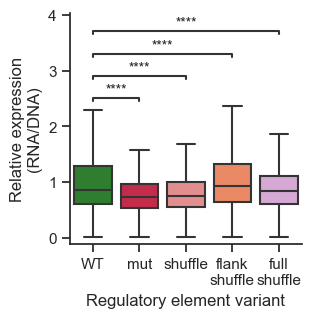

In [21]:
# set variables for stats to place on the graph
# stats used in this graphs is from the table above:
# Kruskal-Wallis followed by Dunn's posthoc test and bonferoni correction for multiple comparisons
pairs = [(i[1]["index"], i[1]["variable"]) for i in dunn.iterrows()]
p_values = [i[1]["value"] for i in dunn.iterrows()]
cols = {'WT':'forestgreen', 'mut':'crimson', 'shuffle':'lightcoral','flankShuffle':'coral','fullShuffle':'plum'}
fig, ax = plt.subplots(figsize=(3,3))
sns.boxplot(data=df[df.cell_line == 'MCF10A'], x='enhancer_variant', y='RNA/DNA',
			showfliers = False, palette = cols,ax=ax).set(xlabel = 'Regulatory element variant',
													 ylabel = 'Relative expression\n(RNA/DNA)',xticklabels=(['WT', 'mut','shuffle','flank\nshuffle','full\nshuffle']))
annotator = Annotator(ax=ax, pairs = pairs, data=df[df.cell_line == 'MCF10A'], x='enhancer_variant',y='RNA/DNA')
annotator.set_pvalues_and_annotate(p_values)
fig.savefig(os.path.join(fig_out_path,'1J.eps'), dpi=300, transparent=True, bbox_inches='tight')